In [26]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def style_diag(data):
    '''author: CJR, https://stackoverflow.com/a/56916315'''
    diag_mask = pd.DataFrame("", index=data.index, columns=data.columns)
    min_axis = min(diag_mask.shape)
    diag_mask.iloc[range(min_axis), range(min_axis)] = 'background-color: yellow'
    return diag_mask

# Metric Analysis: Landcover Prediction

### DataFrame (raw pixel count)

In [28]:
mimer = '/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_count_confusion_matrices/'
#file = mimer + 'confusion_matrix_esri_urban_rural_34512_2018to2022_4.csv'
#file = mimer + 'confusion_matrix_LSTM_esri_urban_rural_34512_2018to2022_1.csv'
file = mimer + 'multi_year_model/confusion_matrix_LSTM_esri_urban_rural_34512_2016to2020_2020.csv'
#file = mimer + 'single_year_model/confusion_matrix_esri_urban_rural_34512.csv'

df_raw_count = pd.read_csv(file, index_col=0)
df_raw_count.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,1004680659,1746845,46420878,417818,1935265,860139,692733,454644
c2:Tree,102915335,33406592006,463786219,169839680,1564491,738330637,54273985,9930561
c3:Flooded Vegetation,5021271,6114633,326853958,2778492,21666,2201960,965097,144689
c4:Crops,3839239,31167822,38722068,889751440,4575204,219383139,37878362,25381531
c5:Bare Ground,21942148,6326138,15157397,20126693,8053319081,206144552,30685772,9373248
c6:Rangeland,37846932,5518584832,1140036066,976133991,918048655,13368875153,282309981,20291972
c7:Rural,246937,1922537,1080473,2127531,711811,2695121,77044628,15163556
c8:Urban,713197,1062825,790147,5776192,137217,784512,50475392,195669357


In [29]:
df_raw_count.sum(axis=1)

c1:Water                  1057208981
c2:Tree                  34947232914
c3:Flooded Vegetation      344101766
c4:Crops                  1250698805
c5:Bare Ground            8363075029
c6:Rangeland             22262127582
c7:Rural                   100992594
c8:Urban                   255408839
dtype: int64

In [30]:
df_new = df_raw_count.sum(axis=1)
df_new = df_new.div(df_new.sum(axis=0), axis=0)
df_new

c1:Water                 0.015416
c2:Tree                  0.509577
c3:Flooded Vegetation    0.005017
c4:Crops                 0.018237
c5:Bare Ground           0.121945
c6:Rangeland             0.324611
c7:Rural                 0.001473
c8:Urban                 0.003724
dtype: float64

# Accuracy

In [31]:
tp = df_raw_count.to_numpy().diagonal().sum()
num_pixels = df_raw_count.to_numpy().sum()
print(f'accuracy: {tp / num_pixels}')

accuracy: 0.8358425012097448


# Recall

### DataFrame (recall)

In [32]:
df_recall = df_raw_count.div(df_raw_count.sum(axis=1), axis=0)
df_recall.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,0.950,0.002,0.044,0.000,0.002,0.001,0.001,0.000
c2:Tree,0.003,0.956,0.013,0.005,0.000,0.021,0.002,0.000
c3:Flooded Vegetation,0.015,0.018,0.950,0.008,0.000,0.006,0.003,0.000
c4:Crops,0.003,0.025,0.031,0.711,0.004,0.175,0.030,0.020
c5:Bare Ground,0.003,0.001,0.002,0.002,0.963,0.025,0.004,0.001
c6:Rangeland,0.002,0.248,0.051,0.044,0.041,0.601,0.013,0.001
c7:Rural,0.002,0.019,0.011,0.021,0.007,0.027,0.763,0.150
c8:Urban,0.003,0.004,0.003,0.023,0.001,0.003,0.198,0.766


### Seaborn Heatmap (Recall)

Text(0.5, 23.52222222222222, 'Predicted label')

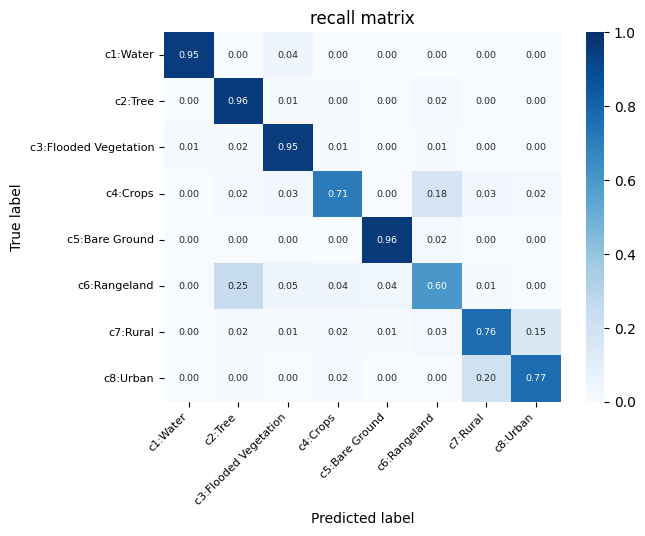

In [33]:
heatmap = sns.heatmap(data=df_recall, vmin=0.0, vmax=1.0, cmap=plt.cm.Blues, annot=True, annot_kws={"fontsize":6.8}, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.title('recall matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Recall score (per class accuracy)

In [34]:
class_names = df_recall.columns
confmat_diag = df_recall.to_numpy().diagonal()
per_class_acc = dict(zip(class_names, confmat_diag))
recall_scores = pd.DataFrame(per_class_acc.items(), columns=['class', 'recall'])
recall_scores = recall_scores.round(3)
print(recall_scores.to_string(index=False))

                class  recall
             c1:Water   0.950
              c2:Tree   0.956
c3:Flooded Vegetation   0.950
             c4:Crops   0.711
       c5:Bare Ground   0.963
         c6:Rangeland   0.601
             c7:Rural   0.763
             c8:Urban   0.766


In [35]:
confmat_diag

array([0.95031415, 0.95591522, 0.94987585, 0.71140345, 0.96296148,
       0.600521  , 0.76287404, 0.76610253])

# Precision

### DataFrame (precision)

In [36]:
df_precision = df_raw_count.div(df_raw_count.sum(axis=0), axis=1)
df_precision.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,0.853,0.000,0.023,0.000,0.000,0.000,0.001,0.002
c2:Tree,0.087,0.857,0.228,0.082,0.000,0.051,0.102,0.036
c3:Flooded Vegetation,0.004,0.000,0.161,0.001,0.000,0.000,0.002,0.001
c4:Crops,0.003,0.001,0.019,0.430,0.001,0.015,0.071,0.092
c5:Bare Ground,0.019,0.000,0.007,0.010,0.897,0.014,0.057,0.034
c6:Rangeland,0.032,0.142,0.561,0.472,0.102,0.920,0.528,0.073
c7:Rural,0.000,0.000,0.001,0.001,0.000,0.000,0.144,0.055
c8:Urban,0.001,0.000,0.000,0.003,0.000,0.000,0.094,0.708


### Seaborn Heatmap (Precision)

Text(0.5, 23.52222222222222, 'Predicted label')

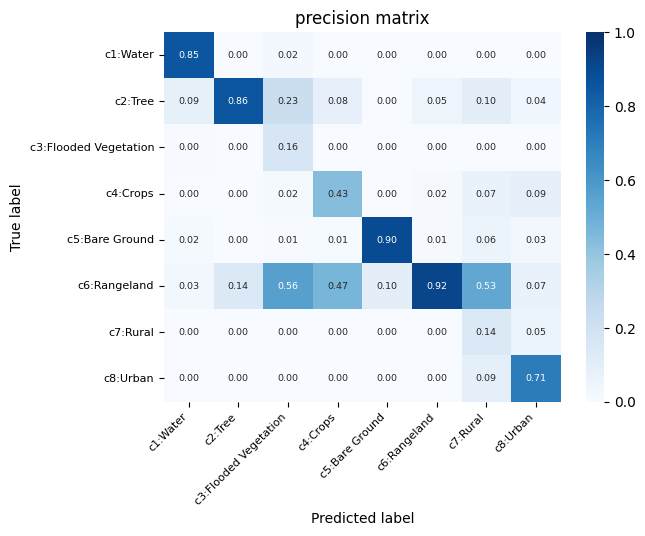

In [37]:
heatmap = sns.heatmap(data=df_precision, vmin=0.0, vmax=1.0, cmap=plt.cm.Blues, annot=True, annot_kws={"fontsize":6.8}, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.title('precision matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Precision score (prediction accuracy)

In [38]:
class_names = df_precision.columns
confmat_diag = df_precision.to_numpy().diagonal()
per_class_acc = dict(zip(class_names, confmat_diag))
precision_scores = pd.DataFrame(per_class_acc.items(), columns=['class', 'precision'])
precision_scores = precision_scores.round(3)
print(precision_scores.to_string(index=False))

                class  precision
             c1:Water      0.853
              c2:Tree      0.857
c3:Flooded Vegetation      0.161
             c4:Crops      0.430
       c5:Bare Ground      0.897
         c6:Rangeland      0.920
             c7:Rural      0.144
             c8:Urban      0.708


In [39]:
confmat_diag

array([0.85344528, 0.85716132, 0.16078629, 0.43046549, 0.89677484,
       0.9195008 , 0.14419032, 0.70789649])

# IoU

In [40]:
class_names = df_raw_count.columns
raw_counts = df_raw_count.to_numpy()
iou_class = {}

# calculate IoU for each class
for i in range(len(class_names)):
    tp = raw_counts[i, i]
    fp = raw_counts[:, i].sum() - tp
    fn = raw_counts[i, :].sum() - tp
    
    nom = tp
    denom = (tp + fp + fn)
    
    if denom != 0:
        iou = nom / denom
    else:
        iou = np.NaN
    iou_class[class_names[i]] = iou


# output IoU as dataframe
iou_scores = pd.DataFrame(iou_class.items(), columns=['class', 'IoU'])
iou_scores.round(3)

,class,IoU
0,c1:Water,0.817
1,c2:Tree,0.825
2,c3:Flooded Vegetation,0.159
3,c4:Crops,0.366
4,c5:Bare Ground,0.867
5,c6:Rangeland,0.571
6,c7:Rural,0.138
7,c8:Urban,0.582


In [41]:
# calculate mean IoU (not counting empty classes)
iou_mean = np.nanmean(iou_scores['IoU'])
iou_mean

0.5406194717629861

# F1 Score (Dice coefficient)

In [42]:
class_names = df_raw_count.columns
raw_counts = df_raw_count.to_numpy()
f1_class = {}

# calculate IoU for each class
for i in range(len(class_names)):
    tp = raw_counts[i, i]
    fp = raw_counts[:, i].sum() - tp
    fn = raw_counts[i, :].sum() - tp
    
    nom = tp
    denom = tp + 0.5*(fp + fn)
    
    if denom != 0:
        f1 = nom / denom
    else:
        f1 = np.NaN
    f1_class[class_names[i]] = f1

# output f1-score as dataframe
f1_scores = pd.DataFrame(f1_class.items(), columns=['class', 'f1-score'])
f1_scores.round(3)

,class,f1-score
0,c1:Water,0.899
1,c2:Tree,0.904
2,c3:Flooded Vegetation,0.275
3,c4:Crops,0.536
4,c5:Bare Ground,0.929
5,c6:Rangeland,0.727
6,c7:Rural,0.243
7,c8:Urban,0.736


In [43]:
# calculate mean f1-score (not counting empty classes)
f1_mean = np.nanmean(f1_scores['f1-score'])
f1_mean

0.6560178041985649

In [44]:
iou_f1 = iou_scores.set_index('class').join(f1_scores.set_index('class'))
iou_f1_mean = pd.DataFrame({'class': ['mean'], 'IoU': [iou_mean], 'f1-score': [f1_mean]}).set_index('class')
iou_f1 = pd.concat([iou_f1, iou_f1_mean])
iou_f1.round(3)

,IoU,f1-score
class,,
c1:Water,0.817,0.899
c2:Tree,0.825,0.904
c3:Flooded Vegetation,0.159,0.275
c4:Crops,0.366,0.536
c5:Bare Ground,0.867,0.929
c6:Rangeland,0.571,0.727
c7:Rural,0.138,0.243
c8:Urban,0.582,0.736
mean,0.541,0.656
